In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns       
from scipy import stats

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

In [28]:
train_data_eda_file="./eda/train_data_eda.csv"
train_label_eda_file="./eda/train_label_eda.csv"
x_train = pd.read_csv(train_data_eda_file)
y_one_hot = pd.read_csv(train_label_eda_file)
feture_qty=x_train.shape[1]
print ("x_train:",x_train.shape)
print ("y_one_hot:",y_one_hot.shape)


x_train: (7160, 292)
y_one_hot: (7160, 6)


## 設定訓練結果存放路徑

In [29]:
import os
model_path = os.path.join(os.getcwd(), 'model')
info_path = model_path + '/info'

if not os.path.isdir(model_path):
    os.makedirs(model_path)
if not os.path.isdir(info_path):
    os.makedirs(info_path)


# 用 keras 建 model

## import keras library

In [30]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping

## 模型訓練參數設定
9/4 目前效果最佳的設定值
model_dropout=0.4
batch_size 128
epochs = 300 #batch_size調大,epochs也要調大
learning_rate = 0.001 #預設即為0.001。這case調大後效果不佳，調小效果也不明顯，所以使用預設值即可 
train_data_ratio = 0.85 # 調整稍有變化。0.9較佳
es_patience=60


In [31]:
# model add parameter
model_dropout=0.4
# model fit parameter
batch_size_list=[128] #測試相同條件下，128最佳
#batch_size_list=[32,64,96,128,160,192,224,256] # 測試相同條件下，128最佳
epochs = 300 #batch_size調大,epochs也要調大
learning_rate = 0.001 #預設即為0.001。這case調大後效果不佳，調小效果也不明顯，所以使用預設值即可 
train_data_ratio = 0.9 # 調整稍有變化。0.85較佳 0.9 -> 0.61872

# check point parameter
cp_monitor='val_acc'

# early stop parameter
es_monitor='val_acc'
es_patience=60

# file
model_file_name_prefix="adam_"
image_file_name_prefix="adam_"
train_file_name_prefix="train.txt"
train_file_name = info_path + "/train.txt"


In [32]:
def train_model(batch_size_in,verbose_in=1):
    #check point
    model_name = model_file_name_prefix + str(batch_size_in)
    plt_name_loss = os.path.join(info_path, image_file_name_prefix + str(batch_size_in) + "_loss.jpg")
    plt_name_acc = os.path.join(info_path, image_file_name_prefix + str(batch_size_in) + "_acc.jpg")
    model_path_name = os.path.join(model_path, model_name)
    checkpoint = ModelCheckpoint(model_path_name, monitor=cp_monitor, 
                             verbose=2, save_best_only=True, save_weights_only=False)
    #early stop
    earlystop = EarlyStopping(monitor=es_monitor, patience=es_patience, verbose=1)    
 

   #使用dropout無太大變化
    #使用2個隱藏層沒太大變化
    model = keras.Sequential()
    model.add(Dropout(model_dropout, input_shape=(feture_qty,)))
    model.add(Dense(200,activation='relu'))
        #model.add(Dense(128, activation='relu', input_shape=(feture_qty,)))
    model.add(Dropout(model_dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(model_dropout))
    model.add(Dense(50, activation='relu')) #多這一層沒幫助
    model.add(Dropout(model_dropout))
    model.add(Dense(6, activation='softmax')) 

  #  print(model.summary())    
    opt=keras.optimizers.Adam(lr=learning_rate)
    #opt=keras.optimizers.SGD() #相同條件下，SGD valid accuracy 0.54562，相較Adam 0.60987差很多
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    #此case加上"shuffle=False"效果比較好一點?
    model_history = model.fit(x=x_train, y=y_one_hot,
                          batch_size=batch_size_in,
                          epochs=epochs,
                          shuffle=False,
                          verbose=verbose_in,
                          validation_split=1 - train_data_ratio, callbacks=[checkpoint,earlystop])
    train_loss = model_history.history['loss']
    train_acc = model_history.history['acc']
    valid_loss = model_history.history['val_loss']
    valid_acc = model_history.history['val_acc']
    valid_acc_max = str(np.array(model_history.history['val_acc']).max())
    del model

    fig = plt.figure()
    plt.plot(train_loss, 'b', label='train')
    plt.plot(valid_loss, 'r', label='valid')
    plt.legend()
    plt.title(str(batch_size_in)  + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig(plt_name_loss)
    plt.show()
    plt.close(fig)
    
    plt.figure()
    plt.plot(train_acc, 'b', label='train')
    plt.plot(valid_acc, 'r', label='valid')
    plt.title(str(batch_size_in) + " Accuracy - Best : " + valid_acc_max)
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend(loc='best')
    plt.savefig(plt_name_acc)
    plt.show()
    
    with open(train_file_name, 'a+') as f :
        f.write('batch_size=' + str(batch_size_in) + '\n')
        f.write('max val_acc=' + valid_acc_max + '\n')
        f.write('\n')
        f.close()
    
    return train_loss,train_acc,valid_loss,valid_acc,model_path_name
    #return valid_acc

## Create model


Epoch 00001: val_acc improved from -inf to 0.29469, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00002: val_acc improved from 0.29469 to 0.35894, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00003: val_acc improved from 0.35894 to 0.40084, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00004: val_acc improved from 0.40084 to 0.48464, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00005: val_acc improved from 0.48464 to 0.50419, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00006: val_acc improved from 0.50419 to 0.52235, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00007: val_acc did not improve from 0.52235

Epoch 00008: val_acc improved from 0.52235 to 0.53492, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128

Epoch 00009: val_acc improved from 0.53492 to 0.53771, 

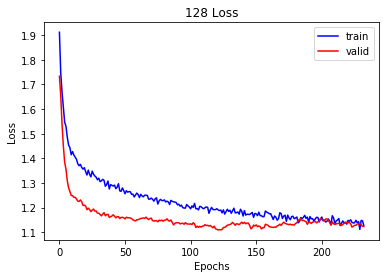

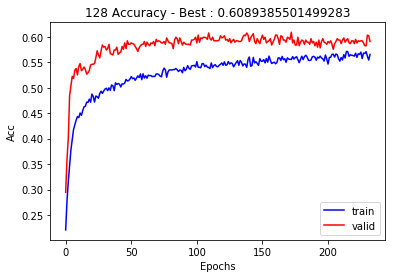

In [33]:
with open(train_file_name, 'w+') as f :
    f.close()

best_valid_acc=0
best_batch_size=0
best_model_path_name=''
for batch_size in batch_size_list:
    _,_,_,valid_acc,model_path_name=train_model(batch_size_in=batch_size,verbose_in=0)
    valid_acc_max=np.array(valid_acc).max()
    if valid_acc_max > best_valid_acc :
        best_valid_acc=valid_acc_max
        best_batch_size=batch_size
        best_model_path_name=model_path_name

with open(train_file_name, 'a+') as f :
    f.write('*** Best result ***' + '\n')
    f.write('best_batch_size=' + str(best_batch_size) + '\n')
    f.write('best_val_acc=' + str(best_valid_acc) + '\n')
    f.write('best_model_file_name=' + best_model_path_name + '\n')
    f.close()
        

In [34]:
print (best_batch_size)
print (best_valid_acc)
best_model_path_name = os.path.join(model_path, 'adam_' + str(best_batch_size))
print (best_model_path_name)

128
0.6089385501499283
/home/jovyan/mypython/Kaggle/AIA Pokemon/model/adam_128
